In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
import cv2
import ujson as json

In [2]:
import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [3]:
import random
from torch.nn.utils import clip_grad_value_
from torch.nn import DataParallel
torch.backends.cudnn.benchmark=True

In [4]:
from tusimple_dataloader import tusimple_dataset
from model import LaneNet
from loss import Losses

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
data_dir = 'data/train_set'
train_set = tusimple_dataset(data_dir, 'train')
val_set = tusimple_dataset(data_dir, 'val')
num_train = len(train_set)
num_val = len(val_set)
batch_size = 16

Check length of dataset

In [8]:
num_train

3216

In [9]:
num_val

410

In [10]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}
print('Finish loading data from %s' % data_dir)

Finish loading data from data/train_set


In [11]:
def init_weights(model):
    if type(model) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
        torch.nn.init.xavier_uniform_(model.weight)
        if model.bias is not None:
            model.bias.data.fill_(0.01)

In [12]:
def plot_img_array(img_array,filenames, ncol=4):
    filenames = list(filenames)
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))
    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i], cmap=plt.cm.gray)
        plots[i // ncol, i % ncol].set_title(filenames[i // ncol])

In [13]:
image, mask, ins_mask, filenames = next(iter(train_loader))

In [14]:
image.shape

torch.Size([16, 3, 256, 512])

In [15]:
image.max()

tensor(255.)

### Check images and masks from train with augs applied

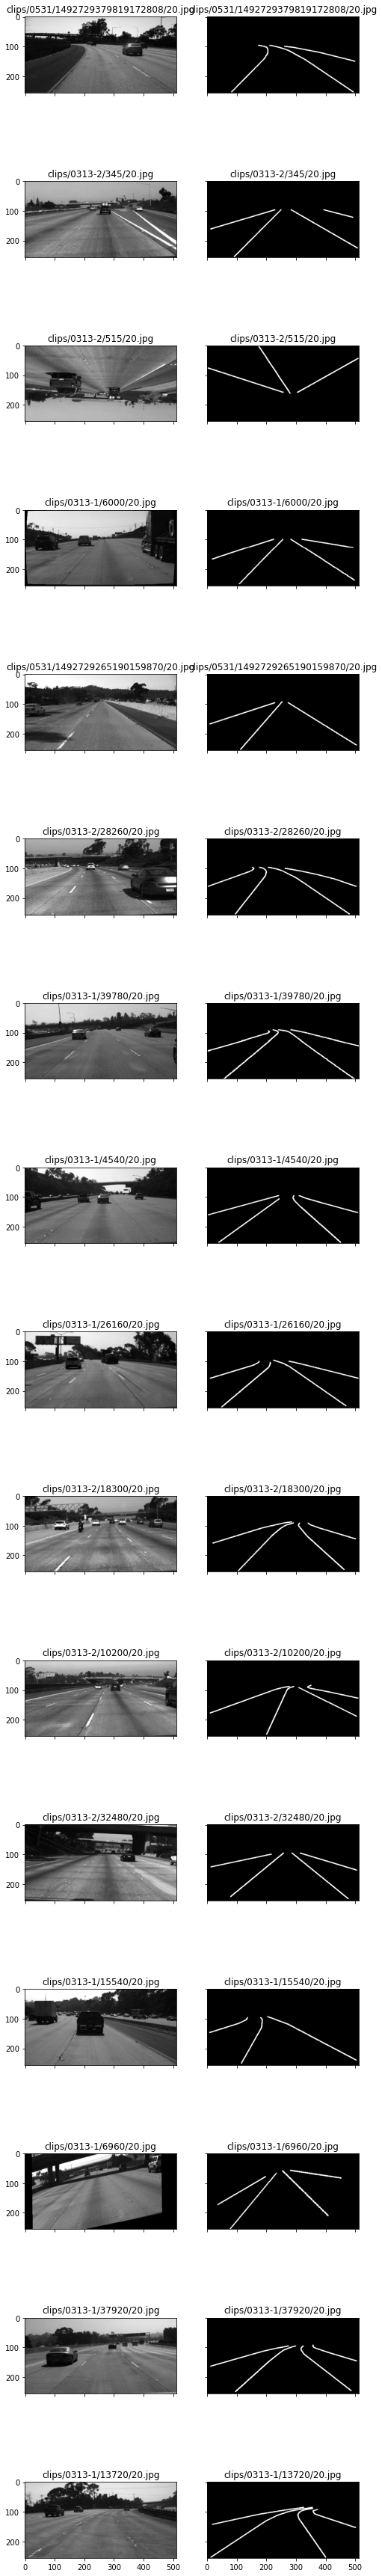

In [16]:
images = image[:,0,:,:]
masks  = mask[:,:,:]

input_images_rgb = [x for x in images]
target_masks_rgb = [x for x in masks]

img_arrays  = [input_images_rgb, target_masks_rgb]

flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))
plot_img_array(flatten_list,filenames, ncol=len(img_arrays))

In [17]:
def build_sampler(train_set, val_set, batch_size):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4,drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4,drop_last=True)
    return {'train':train_loader,'val':val_loader}

In [18]:
class Train:
    def __init__(self,model,loss_params, ops_params,
              dloader, loss = Losses, epoch = 3, batch_size = 16,
              lr=5e-4, optimizer='adam',mode= 'gpu',continue_train=False, save=None):
        self.model=model
        self.data=dloader
        self.epoch=epoch
        self.batch_size=batch_size 
        self.loss=loss
        self.loss_params=loss_params
        self.ops_params=ops_params
        self.lr=lr
        self.optimizer=optimizer
        self.mode=mode
        self.continue_train=continue_train
        self.save=save 
                        
    def _train(self):
        
        if self.mode=='gpu':
            device=torch.device('cuda',0)
            if self.continue_train==True:
                self.model.load_state_dict(torch.load(self.save))
            self.model=self.model.to(device)
        self.model=self.model.train()
        params=self.model.parameters()
        optimizer=self._create_optimizer()
        optimizer=optimizer(params,lr=self.lr,**self.ops_params)

        start_time=int(time.time())
        #log=open('./logs/LaneNet_{}.txt'.format(start_time),'w')
        step=0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_loss = 1000

        for e_p in range(self.epoch):
            print('Epoch {}/{}:'.format(e_p+1, self.epoch))
            since = time.time()

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                epoch_samples = 0

                for input_data, seg_mask, instance_mask, _  in self.data[phase]:
                    s=time.time()
                    
                    input_data=input_data.to(device)
                    seg_mask=seg_mask.to(device)
                    instance_mask=instance_mask.to(device)
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        predictions, embeddings=self.model(input_data)                        
                        total_loss=self.loss(self.batch_size,predictions,
                                             seg_mask,embeddings,instance_mask,**self.loss_params)
                        total_loss,segmentation_loss,discriminative_loss, metrics =total_loss()
                    
                        if phase == 'train':
                            #log.flush()
                            optimizer.zero_grad()
                            total_loss.backward()
                            clip_grad_value_(params,clip_value=5.)
                            optimizer.step()
                    
                    epoch_samples += input_data.size(0)
                    
                computed_metrics = compute_metrics(metrics, epoch_samples)
                print_metrics(computed_metrics, phase)
                epoch_loss = metrics['tot']/ epoch_samples                    
                #log.write(str(print_metrics(computed_metrics, phase)))
                
                if phase == 'val' and epoch_loss < best_loss:
                    print("\tSaving best model, epoch loss {:4f} < best loss {:4f}".format(epoch_loss, best_loss))
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    torch.save(self.model.state_dict(),os.path.join('./logs/models','model_2_{}_{}.pkl'.format(best_loss,e_p)))
                    
            time_elapsed = time.time() - since
            print('\t{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('-' * 10)
        self.model.load_state_dict(best_model_wts)

        #log.close()
    
    def _create_optimizer(self):
        if self.optimizer=='adam':
            return torch.optim.Adam
        elif self.optimizer=='sgd':
            return torch.optim.SGD
        
    def __call__(self):
        self._train()
        
def compute_metrics(metrics, epoch_samples):
    computed_metrics = {}
    for k in metrics.keys():
        computed_metrics[k] = metrics[k] / epoch_samples
    return computed_metrics

def print_metrics(computed_metrics, phase):
    outputs = []
    for k in computed_metrics.keys():
        outputs.append("{}:{:4f}".format(k, computed_metrics[k]))
    print("\t{}-> {}".format(phase.ljust(5), "|".join(outputs)))

### Define hyperparams

In [19]:
batch_size = 8
num_epoch = 200
learning_rate=5e-4
optimizer='adam'

model=LaneNet()
#loss_parameters={'delta_v':0.3,'delta_d':6,'alpha':1,'beta':1,'gamma':.001}
loss_parameters={'delta_v':0.5,'delta_d':3,'alpha':1,'beta':1,'gamma':.001}
optimizer_parameters= {'betas':(.9,.999),'eps':1e-8,'weight_decay':0,'amsgrad':False}
data = build_sampler(train_set = train_set, val_set = val_set, batch_size = batch_size)    

In [20]:
train = Train(model = model ,loss_params = loss_parameters, ops_params = optimizer_parameters,
              dloader = data, loss = Losses, epoch = num_epoch, batch_size = batch_size,
              lr=learning_rate, optimizer= optimizer , mode= 'gpu',continue_train=False, save=None)

### Start training

In [21]:
train()

Epoch 1/200:


/home/ivan/lanenet/loss.py:84: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  indices=(sample_label==vals[j]).nonzero()


	train-> segm:0.000483|discr:0.084417|tot:0.084900
	val  -> segm:0.005203|discr:1.302230|tot:1.307433
	Saving best model, epoch loss 1.307433 < best loss 1000.000000
	1m 56s
----------
Epoch 2/200:


KeyboardInterrupt: 

### Some checks that everything is worked

In [21]:
image, mask, ins_mask, filenames = next(iter(val_loader))

In [22]:
model.load_state_dict(torch.load('best_weights/model_2_0.055047884583473206_52.pkl'))

<All keys matched successfully>

In [23]:
model.cuda();

In [24]:
image = image.to(device)
predictions, embeddings = model(image.cuda())

In [25]:
predictions.shape

torch.Size([16, 2, 256, 512])

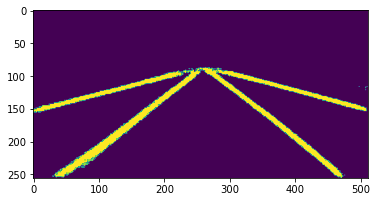

In [26]:
predictions = torch.argmax(F.softmax(predictions, dim=1), dim=1, keepdim=True)
plt.imshow(predictions[0][0].detach().cpu().numpy())

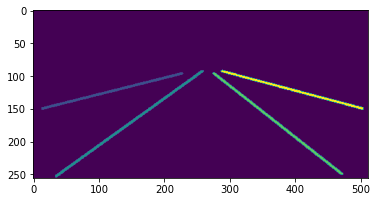

In [27]:
plt.imshow(ins_mask[0].detach().cpu().numpy())

In [28]:
image.shape

torch.Size([16, 3, 256, 512])

In [29]:
image[0].max()

tensor(255., device='cuda:0')